In [1]:
%matplotlib notebook
from IPython.display import Audio as Play
from IPython.display import display
from scipy.io import wavfile
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal.windows import hann
from scipy import signal

In [2]:
# read file
path = "beat.wav"
samplerate, data = wavfile.read(path)
data = data[:, 0]/2**16  # scale between -1 and 1

In [3]:
# plot and play signal
def show_signal(x, samplerate):
    plt.figure()
    plt.plot(np.arange(len(x))/samplerate, x)
    plt.xlabel("time(s)")
    plt.grid(True)
    return Play(x, rate=samplerate)

<IPython.core.display.Javascript object>


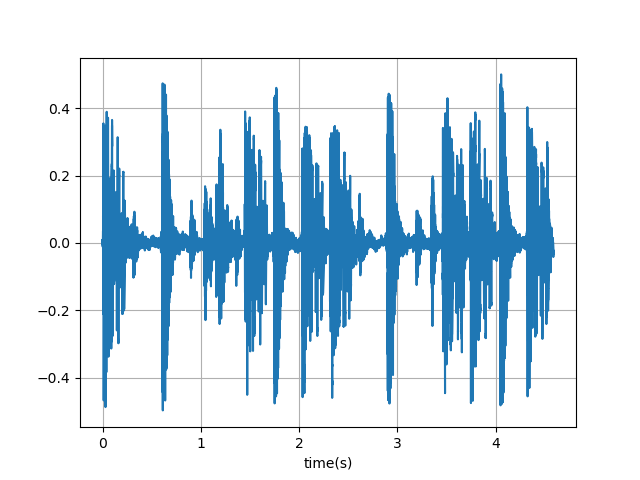

In [4]:
show_signal(data, samplerate)

In [5]:
# we use pandas to have fast frame based processing with little code :)
win_size = 2048
overlap = 1024
idx_frame = np.arange(0, len(data)-win_size, overlap)
df_frames = pd.DataFrame(data=idx_frame, columns=["frame_start"])
df_frames["frames"] = df_frames["frame_start"].apply(lambda x: data[x:(x+win_size)])
df_frames = df_frames.set_index("frame_start", drop=True)
df_frames

,frames
frame_start,
0,"[0.0087890625, 0.008697509765625, 0.0088043212..."
1024,"[0.12542724609375, 0.125762939453125, 0.120666..."
2048,"[0.0831451416015625, 0.0920867919921875, 0.108..."
3072,"[-0.0172882080078125, 0.001617431640625, 0.012..."
4096,"[0.2742156982421875, 0.270263671875, 0.2656097..."
...,...
434176,"[0.0281524658203125, 0.0311431884765625, 0.035..."
435200,"[-0.16729736328125, -0.16796875, -0.1684570312..."
436224,"[0.0676422119140625, 0.06439208984375, 0.05862..."


<IPython.core.display.Javascript object>


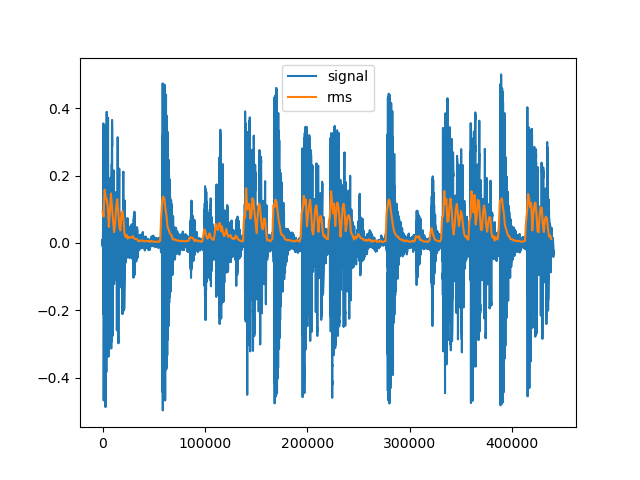

,frames,rms
frame_start,,
0,"[0.0087890625, 0.008697509765625, 0.0088043212...",0.092900
1024,"[0.12542724609375, 0.125762939453125, 0.120666...",0.078191
2048,"[0.0831451416015625, 0.0920867919921875, 0.108...",0.157966
3072,"[-0.0172882080078125, 0.001617431640625, 0.012...",0.136523
4096,"[0.2742156982421875, 0.270263671875, 0.2656097...",0.128684
...,...,...
434176,"[0.0281524658203125, 0.0311431884765625, 0.035...",0.071560
435200,"[-0.16729736328125, -0.16796875, -0.1684570312...",0.040019
436224,"[0.0676422119140625, 0.06439208984375, 0.05862...",0.018873


In [10]:
# extract rms per frame
window = hann(win_size)
df_frames["rms"] = df_frames["frames"].apply(lambda x: np.sqrt(np.mean((x*window)**2)))
plt.figure()
plt.plot(data, label="signal")
plt.plot(df_frames["rms"], label="rms")
plt.legend()
df_frames

<IPython.core.display.Javascript object>


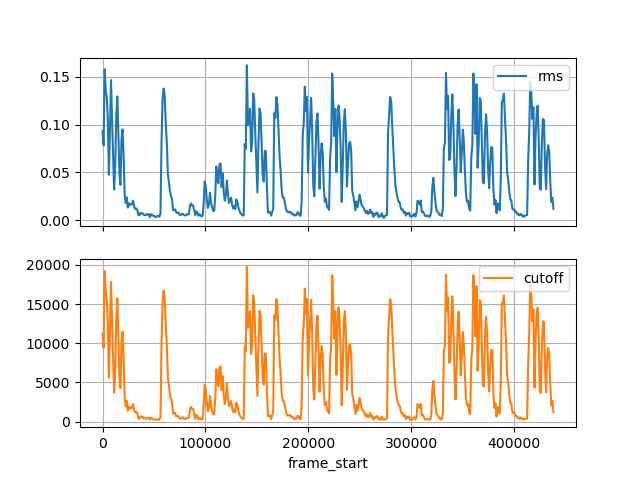

,frames,rms,cutoff
frame_start,,,
0,"[0.0087890625, 0.008697509765625, 0.0088043212...",0.092900,11201.793739
1024,"[0.12542724609375, 0.125762939453125, 0.120666...",0.078191,9386.386795
2048,"[0.0831451416015625, 0.0920867919921875, 0.108...",0.157966,19231.769338
3072,"[-0.0172882080078125, 0.001617431640625, 0.012...",0.136523,16585.422808
4096,"[0.2742156982421875, 0.270263671875, 0.2656097...",0.128684,15617.936940
...,...,...,...
434176,"[0.0281524658203125, 0.0311431884765625, 0.035...",0.071560,8568.109925
435200,"[-0.16729736328125, -0.16796875, -0.1684570312...",0.040019,4675.464800
436224,"[0.0676422119140625, 0.06439208984375, 0.05862...",0.018873,2065.797698


In [12]:
# let's attach the rms to a lowpass filter cutoff frequency :)
# first convert rms to a cutoff value
cutoff = (df_frames["rms"]-df_frames["rms"].min()) / (df_frames["rms"].max() - df_frames["rms"].min())
cutoff_min = 250
cutoff_max = 20000
df_frames["cutoff"] = cutoff*(cutoff_max - cutoff_min)
df_frames["cutoff"] = df_frames["cutoff"].clip(cutoff_min, cutoff_max)
df_frames.plot(subplots=True, grid=True)
df_frames

In [13]:
# now filter each frame
def filter_signal(data):
    frame = data["frames"]
    cutoff = data["cutoff"]
    w = cutoff / (samplerate / 2) # Normalize the frequency
    b, a = signal.butter(5, w, 'low')
    return signal.lfilter(b, a, frame)

df_frames["frames_filtered"] = df_frames[["frames", "cutoff"]].apply(filter_signal, axis=1)
df_frames

,frames,rms,cutoff,frames_filtered
frame_start,,,,
0,"[0.0087890625, 0.008697509765625, 0.0088043212...",0.092900,11201.793739,"[2.1632709176638985e-05, 0.0001866977805646392..."
1024,"[0.12542724609375, 0.125762939453125, 0.120666...",0.078191,9386.386795,"[0.0001461381532145146, 0.0013185771679553062,..."
2048,"[0.0831451416015625, 0.0920867919921875, 0.108...",0.157966,19231.769338,"[0.0018361367223559341, 0.013011478891487715, ..."
3072,"[-0.0172882080078125, 0.001617431640625, 0.012...",0.136523,16585.422808,"[-0.00021189930696159903, -0.00136259672113308..."
4096,"[0.2742156982421875, 0.270263671875, 0.2656097...",0.128684,15617.936940,"[0.0026403697239022225, 0.020355670022909063, ..."
...,...,...,...,...
434176,"[0.0281524658203125, 0.0311431884765625, 0.035...",0.071560,8568.109925,"[2.2166439572908866e-05, 0.0002060998548400898..."
435200,"[-0.16729736328125, -0.16796875, -0.1684570312...",0.040019,4675.464800,"[-8.870868745396728e-06, -8.88403728940303e-05..."
436224,"[0.0676422119140625, 0.06439208984375, 0.05862...",0.018873,2065.797698,"[7.731470419712237e-08, 8.129263620998199e-07,..."


<IPython.core.display.Javascript object>


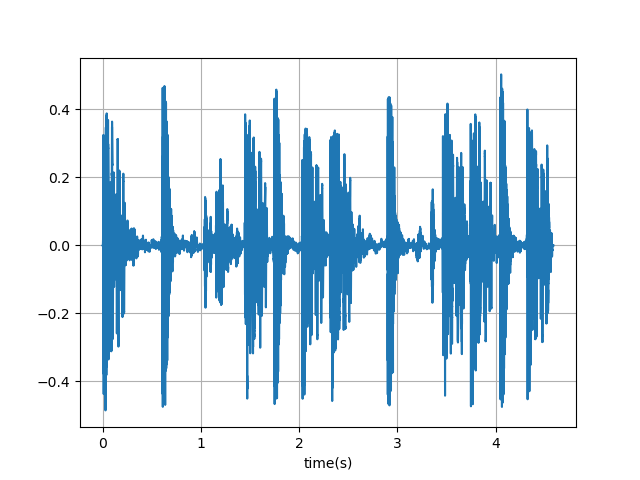

In [14]:
# overlapp add signals windowed
y = np.zeros(len(data))
def overlap_add(x):
    idx_start = x.name
    idx_end = idx_start + win_size
    idx_end = np.min([idx_end, len(y)])
    y[idx_start:idx_end] = y[idx_start:idx_end] + window*x["frames_filtered"]
    
df_frames[["frames_filtered"]].apply(overlap_add, axis=1)
show_signal(y, samplerate)